# STEM Introduction

This notebook demonstrates how to do a basic STEM simulation using PyQSTEM with ASE.

In [1]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from ase.io import read
from pyqstem.util import atoms_plot
from pyqstem import PyQSTEM
from ase.build import mx2
mpl.rc('font',**{'size' : 13})

We create an orthorhombic unit cell of MoS2. The unit cell is repeated 3x3 times, in order to accomodate the size of the probe at all scan positions. We set a scan range that covers the central unit cell.

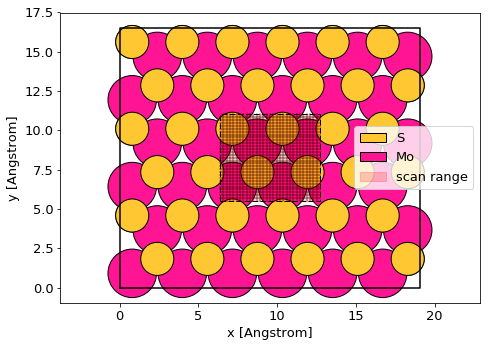

In [2]:
atoms=mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(2, 2, 1), vacuum=2)

cell=atoms.get_cell()
cell[1,0]=0
atoms.set_cell(cell)

atoms.wrap() # wrap atoms outside the unit cell
atoms.center() # center the atoms in the unit cell

atoms*=(3,3,1)

scan_range=[[cell[0,0],2*cell[0,0],30],
            [cell[1,1],2*cell[1,1],30]]

fig,ax=plt.subplots(figsize=(7,5))
atoms_plot(atoms,scan_range=scan_range,ax=ax,legend=True)

We create a QSTEM object in STEM mode and set the atomic object.

In [3]:
qstem = PyQSTEM('STEM')
qstem.set_atoms(atoms)

We build a (very bad) probe. Building the probe will also determine the resolution of the potential, when we build it.

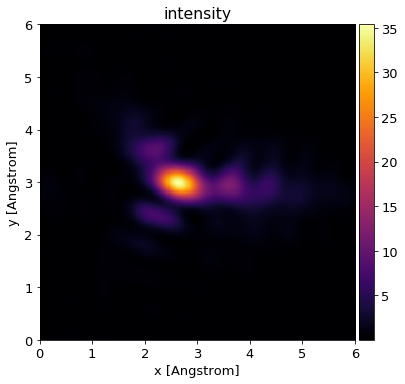

In [15]:
resolution = (0.02,0.02) # resolution in x and y-direction [Angstrom]
samples = (300,300) # samples in x and y-direction 
defocus = -50 # defocus [Angstrom]
v0 = 300 # acceleration voltage [keV]
alpha = 20 # convergence angle [mrad]
astigmatism = 40 # astigmatism magnitude [Angstrom]
astigmatism_angle = 100 # astigmatism angle [deg.]
aberrations = {'a33': 3000, 'phi33': 120} # higher order aberrations [Angstrom] or [deg.]

qstem.build_probe(v0,alpha,(300,300),resolution=(0.02,0.02),defocus=defocus,astig_mag=astigmatism,
                  astig_angle=astigmatism_angle,aberrations=aberrations)
wave=qstem.get_wave()
wave.view(cmap='inferno')

The potential is build and imported to python.

In [16]:
qstem.build_potential(5,scan_range=scan_range)
potential=qstem.get_potential_or_transfunc()

We can view the extent of the potential using the .view() method of the PyQSTEM object. When the potential is build in this way, it is made to cover exactly the maximum probe extent.

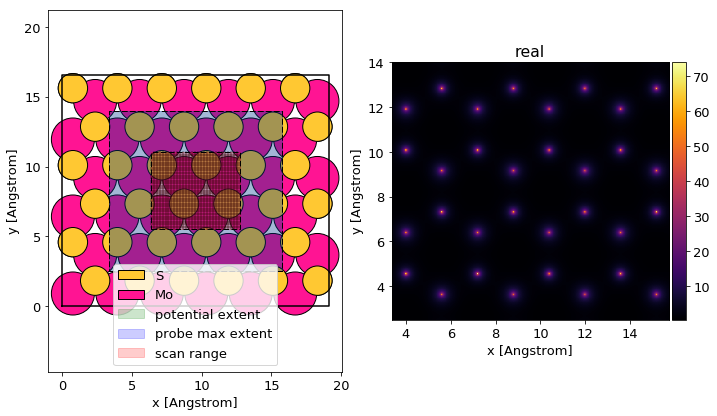

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
qstem.view(ax=ax1)
potential.view(ax=ax2,cmap='inferno',method='real')

We add a couple of detectors and run qstem.

In [18]:
detector1_radii=(70,200) # inner and outer radius of detector 1
detector2_radii=(0,70) # inner and outer radius of detector 2

qstem.add_detector('detector1',detector1_radii)
qstem.add_detector('detector2',detector2_radii)
qstem.run()

After running we can extract the results from the detectors.

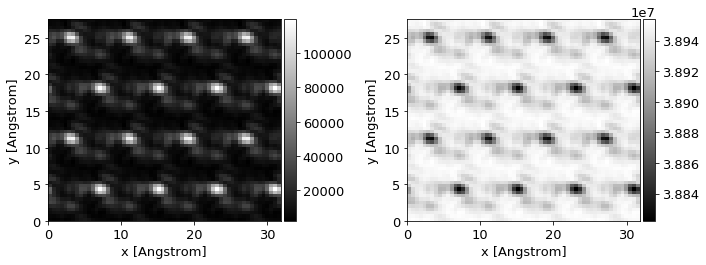

In [19]:
img1=np.array(qstem.read_detector('detector1'))
img2=np.array(qstem.read_detector('detector2'))

img1=np.tile(img1,(2,2))
img2=np.tile(img2,(2,2))

extent=[0,scan_range[0][1]*3-scan_range[0][0],0,scan_range[1][1]*3-scan_range[1][0]]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
ims1=ax1.imshow(img1.T,extent=extent,interpolation='nearest',cmap='gray')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ims1, cax=cax1)
ax1.set_xlabel('x [Angstrom]')
ax1.set_ylabel('y [Angstrom]')

ims2=ax2.imshow(img2.T,extent=extent,interpolation='nearest',cmap='gray')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ims2, cax=cax2)
ax2.set_xlabel('x [Angstrom]')
ax2.set_ylabel('y [Angstrom]')

plt.tight_layout()
plt.show()